In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import os, sys
exec(open("init_notebook.py").read())
from DataTools import DataTools
from Extractor import Extractor
from DataCleaner import DataCleaner
from RepoTools import RepoTools

current working dir/Volumes/Zarif/myStuff/research/repoPaper/src


In [2]:
%load_ext autoreload
%autoreload 2

### Load all the necessary datasets 

In [98]:
# mainDataSet
mainDatasetPath = os.path.join(os.curdir, "../data/mainData.csv")
companyDf = pd.read_csv(mainDatasetPath)

# companyToRepos
companyToRepos = Extractor.getConfig()

# DataByCIDAndYear
dataByCidYear = DataTools.loadCSVFromOutput('finalStuff/DataByCIDAndYearV2')

# matched_papers
matchedPapersInfo = DataTools.loadCSVFromOutput('finalStuff/matched_papersV2')

# pwc
pwc = pwc = pd.read_csv(os.path.join(os.pardir, 'data/papersWithCode.csv'))

# Paper Titles Matched By PWC and companyDf
paperTitles = [title.lower() for title in companyDf['Title']]
matchedPapersInPWC = pwc[pwc['paper_title'].str.lower().isin(paperTitles)]

# getting all the matches having company usernames
usernames = []
for _ in companyToRepos:
    a = ['/' + username + '/' for username in _['repos']]
    usernames.extend(a)
    
matchedHavingUsername = matchedPapersInPWC[matchedPapersInPWC.repo_url.str.contains('|'.join(usernames))]

# companyPWC
companyPWC = pwc[pwc.repo_url.str.contains('|'.join(usernames))]

# matched papers in pwc having company usernames and mentioning paper in the github
matchedHavingUsernameAndGithubMention = matchedHavingUsername[matchedHavingUsername.mentioned_in_github==True]

1072

In [13]:
def getPath(filename):
    return os.path.join(os.curdir, '../figs/' + filename)

### Pi Chart For Number of Company with N users

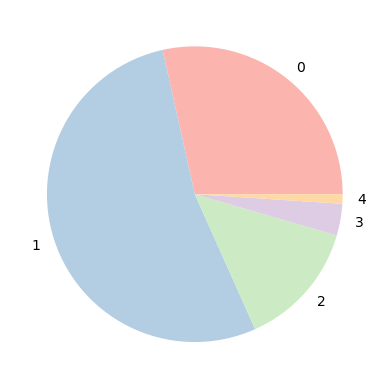

In [22]:
nUsers = []
for _ in companyToRepos:
    nUsers.append(len(_['repos']))
    
nUsersTonCompanies = {0:0, 1:0, 2:0, 3:0, 4:0}
for nUser in nUsers:
    nUsersTonCompanies[nUser] += 1
  
labels = ['0', '1', '2', '3', '4']
data = nUsersTonCompanies.values()
palette_color = sns.color_palette('Pastel1')
plt.pie(data, labels=labels, colors=palette_color)
# plt.show()
sns.set_context('paper')
plt.savefig(getPath('pichart.png'), dpi=300, bbox_inches='tight', transparent=True)

###  finding the top users in company papers having ***matching*** paper mentioned in github

In [104]:
repo_urls = list(matchedHavingUsername[matchedHavingUsername.mentioned_in_github == True].repo_url)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()

[('facebookresearch', 287),
 ('microsoft', 191),
 ('google-research', 108),
 ('google', 76),
 ('IBM', 67),
 ('amazon-research', 37),
 ('deepmind', 35),
 ('huawei-noah', 25),
 ('openai', 21),
 ('NVIDIA', 18),
 ('pfnet-research', 17),
 ('apple', 14),
 ('facebook', 13),
 ('uber-research', 11),
 ('bytedance', 9),
 ('nttcslab', 9),
 ('amzn', 8),
 ('Tencent', 7),
 ('alibaba', 7),
 ('asappresearch', 7),
 ('naver', 7),
 ('salesforce', 6),
 ('AutodeskAILab', 4),
 ('snap-research', 4),
 ('yahoo', 4),
 ('baidu-research', 4),
 ('tencent-ailab', 4),
 ('SRI-CSL', 3),
 ('Schlumberger', 3),
 ('AstraZeneca', 3),
 ('rigetti', 3),
 ('kakaobrain', 3),
 ('dwave-examples', 2),
 ('pfnet', 2),
 ('mozilla', 2),
 ('SAP', 2),
 ('eBay', 2),
 ('bayer-science-for-a-better-life', 2),
 ('ARM-software', 2),
 ('uber', 2),
 ('baidu', 2),
 ('bigvideoresearch', 2),
 ('bloomberg', 2),
 ('Xilinx', 2),
 ('TexasInstruments', 2),
 ('DensoITLab', 2),
 ('adobe-research', 2),
 ('sony', 2),
 ('boschresearch', 2),
 ('linkedin', 2),

###  finding the top users in company papers having ***matching*** paper not mentioned in github

In [55]:
repo_urls = list(matchedHavingUsername[matchedHavingUsername.mentioned_in_github == False].repo_url)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()

[('google-research', 167),
 ('microsoft', 89),
 ('deepmind', 58),
 ('facebookresearch', 47),
 ('IBM', 35),
 ('alibaba', 33),
 ('google', 29),
 ('huawei-noah', 23),
 ('NVIDIA', 12),
 ('amazon-research', 11),
 ('baidu-research', 6),
 ('Accenture', 5),
 ('bytedance', 5),
 ('pfnet-research', 4),
 ('openai', 4),
 ('boschresearch', 3),
 ('asappresearch', 3),
 ('mozilla', 3),
 ('siemens', 3),
 ('nttcslab', 3),
 ('amzn', 3),
 ('tencent-ailab', 2),
 ('linkedin', 2),
 ('apple', 2),
 ('bloomberg', 2),
 ('naver', 2),
 ('baidu', 2),
 ('swisscom', 1),
 ('salesforce', 1),
 ('ThalesGroup', 1),
 ('mitre', 1),
 ('didi', 1),
 ('AstraZeneca', 1),
 ('bayer-science-for-a-better-life', 1),
 ('ydataai', 1),
 ('telekom', 1),
 ('yandex', 1),
 ('awslabs', 1),
 ('turn', 1),
 ('electronicarts', 1),
 ('nec-research', 1),
 ('yahoo', 1),
 ('AutodeskAILab', 1),
 ('bigvideoresearch', 1),
 ('aliyun', 1),
 ('Xilinx', 1),
 ('Telefonica', 1),
 ('huggingface', 1),
 ('Tencent', 1),
 ('Illumina', 1),
 ('sony', 1),
 ('uber-res

###  finding the top users in our finding

In [107]:
repo_urls = list(matchedPapersInfo.repo_link)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()

[('microsoft', 277),
 ('facebookresearch', 185),
 ('IBM', 127),
 ('google-research', 94),
 ('google', 73),
 ('deepmind', 49),
 ('NVlabs', 45),
 ('pfnet-research', 26),
 ('Tencent', 20),
 ('openai', 19),
 ('apple', 18),
 ('alibaba', 17),
 ('bytedance', 16),
 ('huawei-noah', 16),
 ('NVIDIA', 14),
 ('nttcslab', 13),
 ('Xilinx', 12),
 ('linkedin', 11),
 ('AstraZeneca', 11),
 ('uber-research', 11),
 ('tencent-ailab', 10),
 ('asappresearch', 9),
 ('amzn', 9),
 ('nec-research', 9),
 ('google-research-datasets', 9),
 ('salesforce', 8),
 ('baidu-research', 8),
 ('kakaobrain', 8),
 ('naver', 8),
 ('aim-uofa', 7),
 ('cszn', 5),
 ('AutodeskAILab', 5),
 ('adobe-research', 4),
 ('cvgroup-njust', 4),
 ('bloomberg', 4),
 ('bayer-science-for-a-better-life', 4),
 ('Sense-X', 4),
 ('dell-research-harvard', 4),
 ('SRI-CSL', 4),
 ('intel', 4),
 ('Kitware', 4),
 ('boschresearch', 4),
 ('softbankrobotics-research', 4),
 ('snap-research', 4),
 ('eBay', 4),
 ('s3prl', 3),
 ('yahoo', 3),
 ('amd', 3),
 ('DensoIT

### finding missed by us papers (Facebook)

In [121]:
papersByFacebookPWC = matchedPapersInPWC[(matchedPapersInPWC.repo_url.str.contains('facebookresearch')) & (matchedPapersInPWC.mentioned_in_github==True)]
papersByFacebookUs = matchedPapersInfo[matchedPapersInfo.repo_link.str.contains('facebookresearch')]
notIncludedPapers = []
big = list(papersByFacebookPWC.paper_title.str.lower())
smol = list(papersByFacebookUs.Title.str.lower())
for paper in big:
    if paper not in smol:
        notIncludedPapers.append(paper)

In [134]:
missedByUs = papersByFacebookPWC[papersByFacebookPWC.paper_title.str.lower().isin(notIncludedPapers)]

In [147]:
missedByUs.iloc[10:15]

,paper_url,paper_title,paper_arxiv_id,paper_url_abs,paper_url_pdf,repo_url,is_official,mentioned_in_paper,mentioned_in_github,framework
8691,https://paperswithcode.com/paper/clutrr-a-diag...,CLUTRR: A Diagnostic Benchmark for Inductive R...,1908.06177,https://arxiv.org/abs/1908.06177v2,https://arxiv.org/pdf/1908.06177v2.pdf,https://github.com/facebookresearch/clutrr,True,True,True,none
9248,https://paperswithcode.com/paper/word-translat...,Word Translation Without Parallel Data,1710.04087,http://arxiv.org/abs/1710.04087v3,http://arxiv.org/pdf/1710.04087v3.pdf,https://github.com/jiajunhua/facebookresearch-...,False,False,True,pytorch
10258,https://paperswithcode.com/paper/attention-is-...,Attention Is All You Need,1706.03762,http://arxiv.org/abs/1706.03762v5,http://arxiv.org/pdf/1706.03762v5.pdf,https://github.com/facebookresearch/xformers,False,False,True,pytorch
11831,https://paperswithcode.com/paper/embedding-ent...,Embedding Entities and Relations for Learning ...,1412.6575,http://arxiv.org/abs/1412.6575v4,http://arxiv.org/pdf/1412.6575v4.pdf,https://github.com/facebookresearch/PyTorch-Bi...,False,False,True,pytorch
12024,https://paperswithcode.com/paper/on-layer-norm...,On Layer Normalization in the Transformer Arch...,2002.04745,https://arxiv.org/abs/2002.04745v2,https://arxiv.org/pdf/2002.04745v2.pdf,https://github.com/facebookresearch/xformers,False,False,True,pytorch


In [127]:
matchedTemp = DataCleaner.getAllMatchingPapersInfo(companyDf)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 557/557 [00:09<00:00, 61.87it/s]


In [133]:
matchedTemp[matchedTemp.repo_link.str.contains('baidu')]

,Company,EID,CID,Title,Year,Abstract,repo_link,created_at,name,Full Name,Forks,Stars,Watchers,Commits,Branches,Contributors,Open Issues,PullRequests,YearCreated
112,BAIDU,2-s2.0-84997701981,1611.0,Deep speech 2: End-to-end speech recognition i...,2016,We show that an end-to-end deep learning appro...,https://github.com/baidu-research/warp-ctc,2016-01-14 04:53:11,warp-ctc,baidu-research/warp-ctc,1052,4040,4040,101.0,2.0,21.0,89,9.0,2016
115,BAIDU,2-s2.0-85046278038,1611.0,Dynamic Computational Time for Visual Attention,2017,We propose a dynamic computational time model ...,https://github.com/baidu-research/DT-RAM,2017-03-27 20:07:08,DT-RAM,baidu-research/DT-RAM,19,65,65,4.0,1.0,2.0,2,0.0,2017
116,BAIDU,2-s2.0-85059012127,1611.0,Globally normalized reader,2017,Rapid progress has been made towards question ...,https://github.com/baidu-research/GloballyNorm...,2017-07-21 17:09:07,GloballyNormalizedReader,baidu-research/GloballyNormalizedReader,29,60,60,9.0,9.0,3.0,11,8.0,2017
119,BAIDU,2-s2.0-85084072500,1611.0,Proactive human-machine conversation with expl...,2020,Though great progress has been made for human-...,https://github.com/baidu/Dialogue,2018-09-17 07:02:35,Dialogue,baidu/Dialogue,97,442,442,85.0,1.0,7.0,20,1.0,2018
120,BAIDU,2-s2.0-85104807346,1611.0,Familia: A Configurable Topic Modeling Framewo...,2021,"In this paper, we propose a configurable topic...",https://github.com/baidu/Familia,2017-06-14 06:48:21,Familia,baidu/Familia,608,2604,2604,176.0,1.0,10.0,26,0.0,2017
122,BAIDU,2-s2.0-85113490873,1611.0,Pase: Parallelization strategies for efficient...,2021,Training a deep neural network (DNN) requires ...,https://github.com/baidu-research/PaSE,2020-05-19 17:33:17,PaSE,baidu-research/PaSE,1,5,5,330.0,1.0,1.0,0,0.0,2020
123,BAIDU,2-s2.0-85118472996,1611.0,A predicate-function-argument annotation of na...,2020,Existing OIE (Open Information Extraction) alg...,https://github.com/baidu-research/oix,2022-05-12 02:57:51,oix,baidu-research/oix,1,4,4,8.0,1.0,2.0,0,0.0,2022
176,DeepMind Technologies,2-s2.0-84937959846,1265.0,Recurrent models of visual attention,2014,Applying convolutional neural networks to larg...,https://github.com/baidu-research/DT-RAM,2017-03-27 20:07:08,DT-RAM,baidu-research/DT-RAM,19,65,65,4.0,1.0,2.0,2,0.0,2017
335,IBM,2-s2.0-84970003080,2074.0,Deep learning with limited numerical precision,2015,Training of large-scale deep neural networks i...,https://github.com/baidu-research/nervanagpu,2015-05-19 17:42:23,nervanagpu,baidu-research/nervanagpu,15,48,48,2.0,1.0,1.0,0,0.0,2015
1272,Facebook,2-s2.0-85083951495,661.0,Word translation without parallel data,2018,State-of-the-art methods for learning cross-li...,https://github.com/baidu-research/HNN,2019-05-28 21:52:42,HNN,baidu-research/HNN,8,18,18,25.0,1.0,1.0,0,0.0,2019
